In [68]:
import numpy as np
import scipy
from scipy.cluster import hierarchy
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import csv
import copy

from datetime import datetime
%matplotlib inline

In [69]:
# {PatientID -> { delta -> score }}
patient = {}
# Read from CSV and record ALS-FRS score for each patient and with offset
with open('alsfrs.csv') as csvf:
    readCSV = csv.reader(csvf, delimiter=',')
    for i, row in enumerate(readCSV):      
        if i==0: 
            continue
        
        if row[13] and row[12]:
            if row[0] not in patient:
                patient[row[0]] = {float(row[12]): float(row[13])}
            else:
                patient[row[0]][float(row[12])] = float(row[13])

#Create dataframes 
patient_frames = []
for idx, scores in patient.items():
    if len(scores) < 8:
        continue
    dates = []
    alsfrs = []
    for date, score in scores.items():
        dates.append(date)
        alsfrs.append(score)
    
    patient = "Patient_" + idx
    data = {"Time offsets": dates, patient: alsfrs}
    
    df = pd.DataFrame(data, columns=['Time offsets', patient])
    patient_frames.append(df)

print(len(patient_frames))

2351


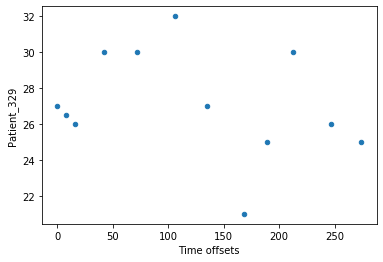

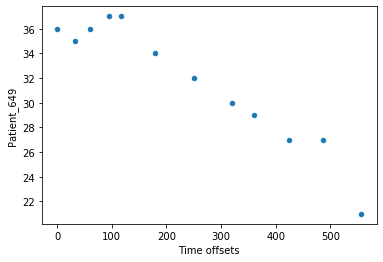

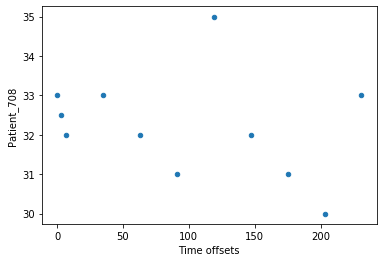

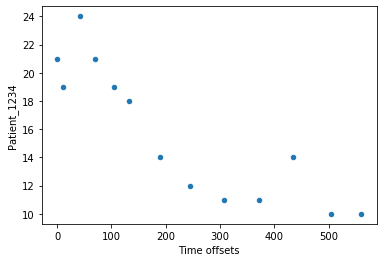

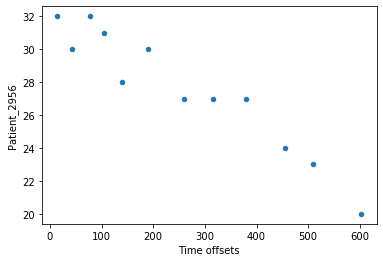

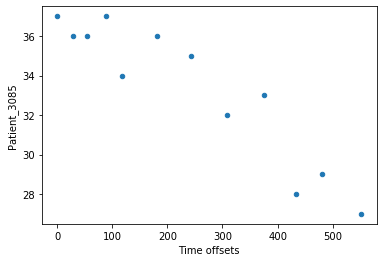

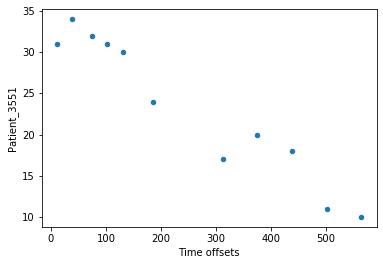

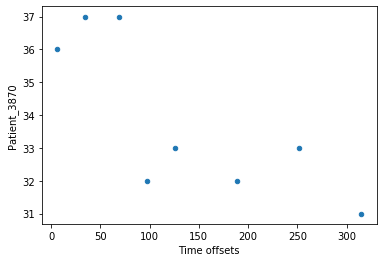

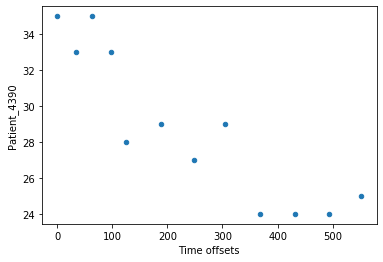

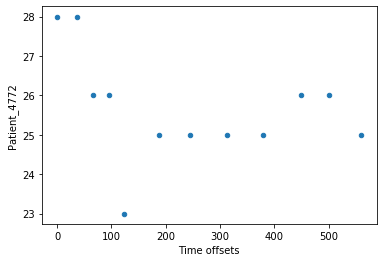

In [70]:
#ALS-FRS graph for each patient over time
for patient in patient_frames[:10]:
    patient.plot(kind="scatter", x=0, y=1)

In [28]:
#Gaussian Process Regression on patients, RBF kernel

# k = GPy.kern.RBF(1)
# k

In [29]:
# Helper function for synthetic data, not needed for PRO-ACT as we have offsets
def datetimeToFloat(dt):
    return (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

In [71]:
#GPR model for first five patients
GPY_models = []
for patient in patient_frames[:50]:
    X = patient.iloc[:, 0].to_numpy()
    Y = patient.iloc[:, 1].to_numpy()
    
    X_len = len(X)
    X = X.reshape((X_len,1))
    Y = Y.reshape((X_len, 1))
    
    m = GPy.models.GPRegression(X, Y)
    m.kern.lengthscale.fix(100)
    
#     k = GPy.kern.PeriodicExponential(input_dim=1,period=1)
#     m = GPy.models.GPRegression(X, Y, k)
    
    m.optimize()
    #m.plot()
    #print("Log likelihood", m.log_likelihood())
    GPY_models.append(m)

# # #Can look at a particular model index if necessary
# GPY_models[1]

# X1 = patient_frames[0].iloc[:, 0].to_numpy()
# X2 = patient_frames[1].iloc[:, 0].to_numpy()
# X1 = X1.reshape((len(X1), 1))
# X2 = X2.reshape((len(X2), 1))
# X = np.vstack([X1,X2])
# ind = np.vstack([np.zeros([len(X1),1]),np.ones([len(X2),1])])
# X = np.hstack([X,ind])
# Y1 = patient_frames[0].iloc[:, 1].to_numpy().reshape((len(X1), 1))
# Y2 = patient_frames[1].iloc[:, 1].to_numpy().reshape((len(X2), 1))
# Y = np.vstack([Y1,Y2])

# plt.plot(X[X[:,1]==0,0],Y[X[:,1]==0],'.')
# plt.plot(X[X[:,1]==1,0],Y[X[:,1]==1],'xr')

# m = GPy.models.GPOffsetRegression(X,Y)
# #m.offset.set_prior(GPy.priors.Gaussian(0,1))
# m.kern.lengthscale.fix(100)
# m.optimize()
# m

# m.plot(fixed_inputs=[(1,0)], legend=None)

# m.plot(fixed_inputs=[(1,0)],legend=None)
# m.log_likleihood()

In [31]:
# Old and possibly broken Node code with offset
class Node:
    def __init__(self, model, data, patients):
        self.model = model
        self.parent = None
        self.data = data
        self.patients = patients
    
    def objective(self):
        return self.model.log_likelihood()
    
    def merge(self, node):
        self.data.extend(node.data)
        #print(self.data)
        self.patients.extend(node.patients)
        X, Y, ind = None, None, None
        Xis, Yis, Indis = [], [], []
        
        for i, patient_frame in enumerate(node.data):
            Xi = patient_frame.iloc[:, 0].to_numpy()
            Xi = Xi.reshape(len(Xi), 1)
            
            Indi = np.full((len(Xi), 1), i)
            
            Yi = patient_frame.iloc[:, 1].to_numpy()
            Yi = Yi.reshape(len(Yi), 1)
            
            Xis.append(Xi)
            Indis.append(Indi)
            Yis.append(Yi)
        
        X = np.vstack(Xis)
        ind = np.vstack(Indis)
        X = np.hstack([X, ind])
        Y = np.vstack(Yis)
        
        #print(X)
        #print(Y)
        
        self.model = GPy.models.GPOffsetRegression(X,Y)
        # m.offset.set_prior(GPy.priors.Gaussian())
        self.model.kern.lengthscale.fix(100)
        self.model.optimize()
        
    def __repr__(self):
        return ",".join(str(id) for id in self.patients)
    
    def plot(self):
        self.model.plot(fixed_inputs=[(1,0)],legend=None)

In [18]:
#Old experiments that revealed node code was broken
model1 = GPY_models[1]
model10 = GPY_models[8]

node1 = Node(model1, [patient_frames[1]], [1])
node10 = Node(model10, [patient_frames[8]], [8])

print("Node 1 obj ", node1.objective())
print("Node 10 obj", node10.objective())

node1.merge(node10)
print("Merge obj", node1.objective())

# node1.merge(node14)
# node1.objective()

Node 1 obj  -23.081994621163926
Node 10 obj -40.539675128224545
Merge obj -40.539675128224545


 c:\users\rob\appdata\local\programs\python\python38-32\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Round complete
Patient cluster [14, 6]
Round complete
Patient cluster [8, 10]
Round complete
Patient cluster [7, 13]
Round complete
Patient cluster [0, 12]
Round complete
Patient cluster [4, 5]
Round complete
Patient cluster [2, 1]
Round complete
Patient cluster [9, 11]
Round complete
Patient cluster [3, 8, 10]
Round complete
Patient cluster [3, 8, 10, 7, 13]
Round complete
Patient cluster [3, 8, 10, 7, 13, 14, 6]
Round complete
Patient cluster [3, 8, 10, 7, 13, 14, 6, 0, 12]
Round complete
Patient cluster [3, 8, 10, 7, 13, 14, 6, 0, 12, 9, 11]
Round complete
Patient cluster [3, 8, 10, 7, 13, 14, 6, 0, 12, 9, 11, 4, 5]
Round complete
Patient cluster [3, 8, 10, 7, 13, 14, 6, 0, 12, 9, 11, 4, 5, 2, 1]


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

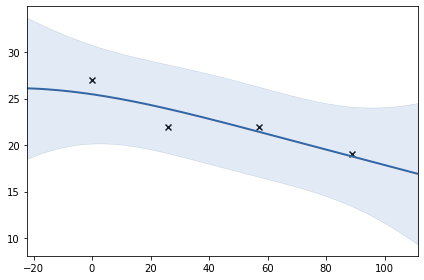

In [32]:
#First version of cluster code with offsets and old node code
tree = []
leaves = []
for i, model in enumerate(GPY_models):
    n = Node(model, [patient_frames[i]], [i])
    leaves.append(n)

tree.append(leaves)

while len(tree[-1]) > 1:
    highest = copy.deepcopy(tree[-1][0])
    highest.merge(tree[-1][1])
    highest_l = (tree[-1][0].objective() - tree[-1][1].objective()) - highest.objective()
    highest_i = (0, 1)
    
    for i1, n1 in enumerate(tree[-1]):
        for i2, n2 in enumerate(tree[-1]):
            if i1 == i2: 
                continue
            else:
                temp = copy.deepcopy(n1)
                temp.merge(n2)
                #print("Comparing ", n1, n2)
                #print("Merged likelihood ", temp.objective())
                if (n1.objective() - n2.objective()) - temp.objective() < highest_l:
                    highest_l = (n1.objective() - n2.objective()) - temp.objective()
                    highest = temp
                    highest_i = (i1, i2)
            #print("Tested ", i1, " and ", i2)
    
    next_layer = [highest]
    next_layer.extend(x for i,x in enumerate(tree[-1]) if (i!=highest_i[0]) and (i!=highest_i[1]))
    tree.append(next_layer)
    print("Round complete")
    print("Patient cluster", highest.patients )

tree[1][0].plot()
tree[2][0].plot()

In [13]:
#Example code MS
XA = np.linspace(0,5,25)[:,None]
yA = 1*XA
mA = GPy.models.GPRegression(XA,yA)
print(mA.log_likelihood())

XB = np.linspace(0,5,10)[:,None]
yB = -0.6*XB
mB = GPy.models.GPRegression(XB,yB)
print(mB.log_likelihood())

XC = np.linspace(3,6,15)[:,None]
yC = 0.7*XC
mC = GPy.models.GPRegression(XC,yC)
print(mC.log_likelihood())

mAB = GPy.models.GPRegression(np.r_[XA,XB],np.r_[yA,yB])
mAC = GPy.models.GPRegression(np.r_[XA,XC],np.r_[yA,yC])
mBC = GPy.models.GPRegression(np.r_[XB,XC],np.r_[yB,yC])
mABC = GPy.models.GPRegression(np.r_[XA,XB,XC],np.r_[yA,yB,yC])

print("A+B sep:",mA.log_likelihood() + mB.log_likelihood()," combined:",mAB.log_likelihood(), "--->", (mA.log_likelihood() + mB.log_likelihood())-mAB.log_likelihood())
print("A+C sep:",mA.log_likelihood() + mC.log_likelihood()," combined:",mAC.log_likelihood(), "--->", (mA.log_likelihood() + mC.log_likelihood())-mAC.log_likelihood())
print("B+C sep:",mB.log_likelihood() + mC.log_likelihood()," combined:",mBC.log_likelihood(), "--->", (mB.log_likelihood() + mC.log_likelihood())-mBC.log_likelihood())
print("A+B+C sep:",mA.log_likelihood() + mB.log_likelihood() + mC.log_likelihood()," combined:",mABC.log_likelihood(), "--->", (mA.log_likelihood() + mB.log_likelihood() + mC.log_likelihood())-mABC.log_likelihood())

-38.73496688486775
-15.41755062860676
-25.26950189095658
A+B sep: -54.152517513474514  combined: -118.87861379157545 ---> 64.72609627810093
A+C sep: -64.00446877582434  combined: -57.910657909222294 ---> -6.093810866602041
B+C sep: -40.68705251956334  combined: -81.7692876143649 ---> 41.08223509480156
A+B+C sep: -79.4220194044311  combined: -141.57916148013035 ---> 62.157142075699255


In [10]:
GPY_models[1]

GP_regression.,value,constraints,priors
rbf.variance,356.2965450670866,+ve,
rbf.lengthscale,100.0,+ve fixed,
Gaussian_noise.variance,5.117712678177898,+ve,


In [78]:
## Working synethetic clustering code


#Synth cluster 1
XA = np.linspace(0,5,25)[:,None]
yA = 2.3*XA
mA = GPy.models.GPRegression(XA,yA)
print(mA.log_likelihood())

X2A = np.linspace(0,5,25)[:,None]
y2A = 1.75*XA
m2A = GPy.models.GPRegression(X2A,y2A)
print(mA.log_likelihood())

X3A = np.linspace(0,5,25)[:,None]
y3A = 1.5*XA
m3A = GPy.models.GPRegression(X3A,y3A)
print(mA.log_likelihood())

#Synth cluster 2
XB = np.linspace(0,5,10)[:,None]
yB = -0.6*XB
mB = GPy.models.GPRegression(XB,yB)
print(mB.log_likelihood())

X2B = np.linspace(0,5,10)[:,None]
y2B = -0.35*XB
m2B = GPy.models.GPRegression(X2B,y2B)
print(mB.log_likelihood())

X3B = np.linspace(0,5,10)[:,None]
y3B = -0.35*XB
m3B = GPy.models.GPRegression(X3B,y3B)
print(mB.log_likelihood())

# mA1A2 = GPy.models.GPRegression(np.r_[XA,X2A],np.r_[yA,y2A])
# mA1B1 = GPy.models.GPRegression(np.r_[XA,XB],np.r_[yA,yB])
# print("LL A1 A2 separate: ", mA.log_likelihood() + m2A.log_likelihood(), " combined --> ", (mA1A2.log_likelihood()))
# print("LL A1 B1 separate: ", mA.log_likelihood() + mB.log_likelihood(), " combined --> ", (mA1B1.log_likelihood()))
class SynthNode:
    def __init__(self, X, Y, model, name, idx):
        self.X = X
        self.Y = Y
        self.m = model
        self.name = name
        self.formation_iteration = -1
        self.original_idx = idx
        self.count = 1
        
    def merge(self, node2):
        self.X = np.r_[self.X,node2.X]
        self.Y = np.r_[self.Y,node2.Y]
        self.m = GPy.models.GPRegression(self.X,self.Y)
        
        self.count += node2.count
        self.name = self.name + " " + node2.name
        
    def __repr__(self):
        return self.name

synth_nodes = [SynthNode(XA, yA, mA, "A1", 0), SynthNode(X2A, y2A, m2A, "A2", 1), SynthNode(X3A, y3A, m3A, "A3", 2), SynthNode(XB, yB, mB, "B1", 3), SynthNode(X2B, y2B, m2B,"B2", 4), SynthNode(X3B, y3B, m3B, "B3", 5)]

tree = []
leaves = synth_nodes
tree.append(leaves)

num_samples = len(tree[0])
Z = np.zeros((len(tree[0])-1, 4))

iteration = 0
print(iteration)

while len(tree[-1]) > 1:
    highest = copy.deepcopy(tree[-1][0])
    highest.merge(tree[-1][1])
    highest_l = (tree[-1][0].m.log_likelihood() + tree[-1][1].m.log_likelihood()) - highest.m.log_likelihood()
    highest_i = (0, 1)
    
    #record cluster membership to update linkage matrix 
    member_1 = tree[-1][0]
    member_2 = tree[-1][1]
    
    for i1, n1 in enumerate(tree[-1]):
        for i2, n2 in enumerate(tree[-1]):
            if i1 == i2: 
                continue
            else:
                temp = copy.deepcopy(n1)
                temp.merge(n2)
                #print("Comparing ", n1, n2)
                #print("Merged likelihood ", temp.objective())
                if (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood() < highest_l:
                    highest_l = (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood()
                    highest = temp
                    highest_i = (i1, i2)
                    
                    member_1 = n1 
                    member_2 = n2
            #print("Tested ", i1, " and ", i2)
            
    highest.formation_iteration = iteration

    member_1_idx = member_1.original_idx if member_1.formation_iteration == -1 else member_1.formation_iteration + num_samples
    member_2_idx = member_2.original_idx if member_2.formation_iteration == -1 else member_2.formation_iteration + num_samples
    sample_count = member_1.count + member_2.count
    
    Z[iteration] = np.array([member_1_idx, member_2_idx, abs(highest_l), sample_count])
    
    next_layer = [highest]
    next_layer.extend(x for i,x in enumerate(tree[-1]) if (i!=highest_i[0]) and (i!=highest_i[1]))
    tree.append(next_layer)
    
    iteration += 1
    print("Round complete")
    print(tree[-1])
    print(Z)
    

-89.12463108953551
-89.12463108953551
-89.12463108953551
-15.41755062860676
-15.41755062860676
-15.41755062860676
0
Round complete
[A1 A2, A3, B1, B2, B3]
[[ 0.         1.        31.7680277  2.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
Round complete
[A1 A2 A3, B1, B2, B3]
[[ 0.          1.         31.7680277   2.        ]
 [ 6.          2.         16.81376175  3.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Round complete
[B2 B3, A1 A2 A3, B1]
[[ 0.          1.         31.7680277   2.        ]
 [ 6.          2.         16.81376175  3.        ]
 [ 4.          5.          2.38829584  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Round complete
[B2 B3 

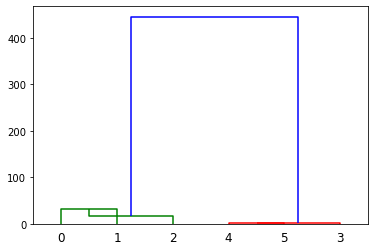

In [80]:
# Dendrogram synth data
plt.figure()
dn = hierarchy.dendrogram(Z)

In [72]:
#Real clustering, no offset, dendrogram enabled 

class RealNoOffsetNode:
    def __init__(self, X, Y, model, name, idx):
        self.X = X
        self.Y = Y
        self.m = model
        self.name = name
        self.formation_iteration = -1
        self.original_idx = idx
        self.count = 1
        
    def merge(self, node2):
        self.X = np.r_[self.X,node2.X]
        self.Y = np.r_[self.Y,node2.Y]
        self.m = GPy.models.GPRegression(self.X,self.Y)
        self.m.kern.lengthscale.fix(100)
        self.m.optimize()
        
        self.count += node2.count
        self.name = self.name + " " + node2.name
        
    def __repr__(self):
        return self.name
    
tree = []
leaves = []
for i, model in enumerate(GPY_models):
    X = patient_frames[i].iloc[:, 0].to_numpy()
    Y = patient_frames[i].iloc[:, 1].to_numpy()
    
    X = X.reshape((len(X),1))
    Y = Y.reshape((len(Y), 1))
    
    n = RealNoOffsetNode(X, Y, model, str(i), i)
    leaves.append(n)

tree.append(leaves)

num_samples = len(tree[0])
Z = np.zeros((len(tree[0])-1, 4))

iteration = 0
print(iteration)
while len(tree[-1]) > 1:
    highest = copy.deepcopy(tree[-1][0])
    highest.merge(tree[-1][1])
    highest_l = (tree[-1][0].m.log_likelihood() + tree[-1][1].m.log_likelihood()) - highest.m.log_likelihood()
    highest_i = (0, 1)

    #record cluster membership to update linkage matrix 
    member_1 = tree[-1][0]
    member_2 = tree[-1][1]

    for i1, n1 in enumerate(tree[-1]):
        for i2, n2 in enumerate(tree[-1]):
            if i1 == i2: 
                continue
            else:
                temp = copy.deepcopy(n1)
                temp.merge(n2)
                #print("Comparing ", n1, n2)
                #print("Merged likelihood ", temp.objective())
                if (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood() < highest_l:
                    highest_l = (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood()
                    highest = temp
                    highest_i = (i1, i2)
                    
                    
                    member_1 = n1 
                    member_2 = n2
            #print("Tested ", i1, " and ", i2)
    
    highest.formation_iteration = iteration

    member_1_idx = member_1.original_idx if member_1.formation_iteration == -1 else member_1.formation_iteration + num_samples
    member_2_idx = member_2.original_idx if member_2.formation_iteration == -1 else member_2.formation_iteration + num_samples
    sample_count = member_1.count + member_2.count
    
    Z[iteration] = np.array([member_1_idx, member_2_idx, abs(highest_l), sample_count])
    
    next_layer = [highest]
    next_layer.extend(x for i,x in enumerate(tree[-1]) if (i!=highest_i[0]) and (i!=highest_i[1]))
    tree.append(next_layer)
    
    iteration += 1
    
    print("Round complete")
    #print(tree[-1])
    #print(Z)


0
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete
Round complete


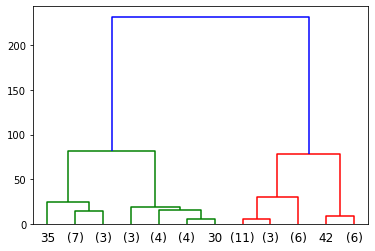

In [77]:
#Dendrogram of real no offset
plt.figure()
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=12)

In [36]:
# Real clustering, offset attempted
# add linkage matrix computation to clustering 



class RealOffsetNode:
    def __init__(self, X, Y, model, name, idx):
        self.X = [X]
        self.Y = [Y]
        self.m = model
        self.name = name
        self.formation_iteration = -1
        self.original_idx = idx
        self.count = 1
        
    def merge(self, node2):
        self.X.extend(node2.X)
        self.Y.extend(node2.Y)
        
        model_X = np.vstack(self.X)
        model_ind = np.vstack([np.full((len(x), 1), i) for i, x in enumerate(self.X)])
        model_X = np.hstack([model_X,model_ind])
        model_Y = np.vstack(self.Y)
        self.m = GPy.models.GPOffsetRegression(model_X,model_Y)
        #m.offset.set_prior(GPy.priors.Gaussian(60,4))
        self.m.kern.lengthscale.fix(100)
        self.m.optimize()
        
        self.count += node2.count 
        self.name = self.name + " " + node2.name
        
    def __repr__(self):
        return self.name
    
tree = []
leaves = []
for i, model in enumerate(GPY_models):
    X = patient_frames[i].iloc[:, 0].to_numpy()
    Y = patient_frames[i].iloc[:, 1].to_numpy()
    
    X = X.reshape((len(X),1))
    Y = Y.reshape((len(Y), 1))
    
    n = RealOffsetNode(X, Y, model, str(i), i)
    leaves.append(n)

tree.append(leaves)

num_samples = len(tree[0])
#LM set to zero
Z = np.zeros((len(tree[0])-1, 4))

iteration = 0
print(tree[-1])
while len(tree[-1]) > 1:
    
    
    highest = copy.deepcopy(tree[-1][0])
    highest.merge(tree[-1][1])
    highest_l = (tree[-1][0].m.log_likelihood() + tree[-1][1].m.log_likelihood()) - highest.m.log_likelihood()
    highest_i = (0, 1)
    
    #record cluster membership to update linkage matrix 
    member_1 = tree[-1][0]
    member_2 = tree[-1][1]

    for i1, n1 in enumerate(tree[-1]):
        for i2, n2 in enumerate(tree[-1]):
            if i1 == i2: 
                continue
            else:
                temp = copy.deepcopy(n1)
                temp.merge(n2)
                #print("Comparing ", n1, n2)
                #print("Merged likelihood ", temp.objective())
                if (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood() < highest_l:
                    highest_l = (n1.m.log_likelihood() + n2.m.log_likelihood()) - temp.m.log_likelihood()
                    highest = temp
                    highest_i = (i1, i2)
                    
                    member_1 = n1 
                    member_2 = n2
            #print("Tested ", i1, " and ", i2)
    
    
    #Record when cluster was made 
    highest.formation_iteration = iteration
    
    #Update linkage matrix
    member_1_idx = member_1.original_idx if member_1.formation_iteration == -1 else member_1.formation_iteration + num_samples
    member_2_idx = member_2.original_idx if member_2.formation_iteration == -1 else member_2.formation_iteration + num_samples
    sample_count = member_1.count + member_2.count
    
    Z[iteration] = np.array([member_1_idx, member_2_idx, abs(highest_l), sample_count])
    
    next_layer = [highest]
    next_layer.extend(x for i,x in enumerate(tree[-1]) if (i!=highest_i[0]) and (i!=highest_i[1]))
    tree.append(next_layer)
    
    iteration += 1
    
    print("Round complete")
    print(tree[-1])
    print(Z)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Round complete
[8 2, 0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
[[ 8.          2.         16.07253728  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Round complete
[7 5, 8 2, 0, 1, 3, 4, 6, 9, 10, 11, 12, 13, 14]
[[ 8.          2.         16.07253728  2.        ]
 [ 7.          5.         13.97489035  2.        ]
 [ 

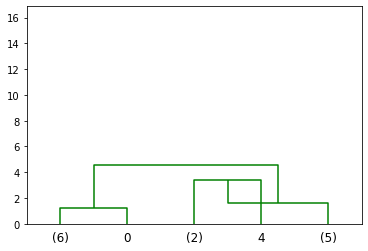

In [47]:
plt.figure()
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=5)